# Previous Trial Effects by Ambiguity Level

This notebook investigates whether **previous trial effects** differ based on **ambiguity level**.

**Hypothesis**: 
- In **high ambiguity** trials (uncertain probabilities), participants may rely more on previous trial outcomes
- In **low ambiguity** trials (clear probabilities), participants may rely more on the actual EV

**Analysis**:
1. Split data by ambiguity (low vs high)
2. Compare transition probabilities in each group
3. Compare model accuracy with/without sequential features in each group

In [18]:
# ============================================================================
# CONFIGURATION
# ============================================================================
TIMEFRAME = 'PRE'  # Options: 'PRE', 'POST'
# ============================================================================

import sys
sys.path.append('../..')

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut, GroupKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

from src.utils.io import load_features, save_results
from src.visualization.plots import set_style

np.random.seed(42)
set_style('whitegrid')

print(f"\n{'='*70}")
print(f"PREVIOUS TRIAL EFFECTS BY AMBIGUITY: {TIMEFRAME}-DECISION")
print(f"{'='*70}\n")


PREVIOUS TRIAL EFFECTS BY AMBIGUITY: PRE-DECISION



## 1. Load Data and Add Sequential Features

In [19]:
# Load pre-extracted features
features_path = f'../../data/results/features_{TIMEFRAME}/extracted_features_{TIMEFRAME}.pkl'
feature_data = load_features(features_path, timeframe=TIMEFRAME)

merged_df = feature_data['merged_df'].copy()
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

print(f"Loaded {len(merged_df)} trials from {merged_df['subject_id'].nunique()} subjects")
print(f"\nAmbiguity distribution:")
print(merged_df['ambiguity'].describe())

Loaded 12511 trials from 97 subjects

Ambiguity distribution:
count    12511.000000
mean         2.998801
std          2.450811
min          0.000000
25%          0.000000
50%          3.000000
75%          6.000000
max          6.000000
Name: ambiguity, dtype: float64


In [20]:
# Extract trial number and sort
def extract_trial_number(trial_id):
    parts = trial_id.split('_')
    return int(parts[0])

merged_df['trial_number'] = merged_df['trial_id'].apply(extract_trial_number)
merged_df = merged_df.sort_values(['subject_id', 'trial_number']).reset_index(drop=True)

# Add sequential features
def add_sequential_features(df, group_col='subject_id'):
    df['prev_outcome'] = df.groupby(group_col)['outcome'].shift(1)
    df['prev_outcome_2'] = df.groupby(group_col)['outcome'].shift(2)
    df['running_invest_rate'] = df.groupby(group_col)['outcome'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    df['recent_invest_rate_5'] = df.groupby(group_col)['outcome'].transform(
        lambda x: x.rolling(window=5, min_periods=1).mean().shift(1)
    )
    df['trial_position'] = df.groupby(group_col)['trial_number'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6)
    )
    
    def count_consecutive(series):
        result = [0]
        count = 0
        for i in range(1, len(series)):
            if series.iloc[i-1] == series.iloc[i-2] if i > 1 else True:
                count += 1
            else:
                count = 0
            result.append(count)
        return pd.Series(result, index=series.index)
    
    df['consecutive_same'] = df.groupby(group_col)['outcome'].transform(count_consecutive)
    return df

merged_df = add_sequential_features(merged_df)
sequential_cols = ['prev_outcome', 'prev_outcome_2', 'running_invest_rate', 
                   'recent_invest_rate_5', 'trial_position', 'consecutive_same']

# Filter to valid trials (with previous outcome)
df_valid = merged_df[merged_df['prev_outcome'].notna()].copy()
print(f"Trials with valid sequential features: {len(df_valid)}")

Trials with valid sequential features: 12414


In [21]:
# Split by ambiguity level (discrete values: 0, 3, 6)
# Following the same method as notebooks/fusion_models/ambiguity_group_late_fusion.ipynb
df_valid['ambiguity_group'] = df_valid['ambiguity'].replace({0: 'Low', 3: 'Medium', 6: 'High'})

# Convert to categorical with proper ordering
df_valid['ambiguity_group'] = pd.Categorical(df_valid['ambiguity_group'], 
                                              categories=['Low', 'Medium', 'High'], 
                                              ordered=True)

print(f"Ambiguity values in data: {sorted(df_valid['ambiguity'].unique())}")
print(f"\nTrials by ambiguity group:")
print(df_valid['ambiguity_group'].value_counts().sort_index())

print(f"\nAmbiguity value by group:")
print(df_valid.groupby('ambiguity_group')['ambiguity'].agg(['min', 'max', 'mean']))

Ambiguity values in data: [np.int64(0), np.int64(3), np.int64(6)]

Trials by ambiguity group:
ambiguity_group
Low       4143
Medium    4129
High      4142
Name: count, dtype: int64

Ambiguity value by group:
                 min  max  mean
ambiguity_group                
Low                0    0   0.0
Medium             3    3   3.0
High               6    6   6.0


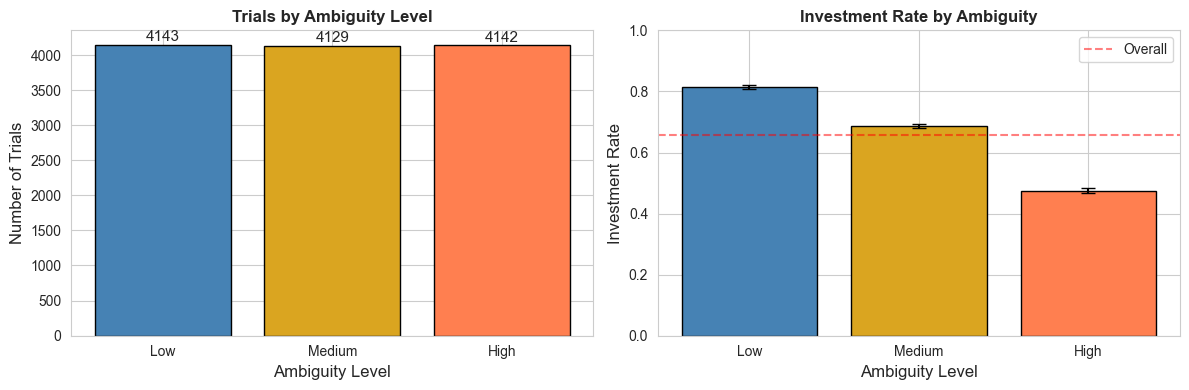

In [22]:
# Visualize ambiguity distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart of trials per ambiguity level
ax1 = axes[0]
counts = df_valid['ambiguity_group'].value_counts().sort_index()
colors = ['steelblue', 'goldenrod', 'coral']
bars = ax1.bar(counts.index, counts.values, color=colors, edgecolor='black')
ax1.set_xlabel('Ambiguity Level', fontsize=12)
ax1.set_ylabel('Number of Trials', fontsize=12)
ax1.set_title('Trials by Ambiguity Level', fontsize=12, fontweight='bold')

# Add value labels
for bar, count in zip(bars, counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{count}', ha='center', fontsize=11)

# Investment rate by ambiguity group
ax2 = axes[1]
invest_by_group = df_valid.groupby('ambiguity_group')['outcome'].agg(['mean', 'sem'])
bars = ax2.bar(invest_by_group.index, invest_by_group['mean'], 
               yerr=invest_by_group['sem'], capsize=5, color=colors, edgecolor='black')
ax2.axhline(y=df_valid['outcome'].mean(), color='red', linestyle='--', alpha=0.5, label='Overall')
ax2.set_ylabel('Investment Rate', fontsize=12)
ax2.set_xlabel('Ambiguity Level', fontsize=12)
ax2.set_title('Investment Rate by Ambiguity', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.legend()

plt.tight_layout()
plt.show()

## 3. Transition Probabilities by Ambiguity

In [23]:
print("="*70)
print("TRANSITION PROBABILITIES BY AMBIGUITY")
print("="*70)

transition_results = []

for group in df_valid['ambiguity_group'].cat.categories:
    df_group = df_valid[df_valid['ambiguity_group'] == group]
    
    prev_invest = df_group[df_group['prev_outcome'] == 1]
    prev_keep = df_group[df_group['prev_outcome'] == 0]
    
    p_invest_after_invest = prev_invest['outcome'].mean()
    p_invest_after_keep = prev_keep['outcome'].mean()
    
    # Chi-square test
    contingency = pd.crosstab(df_group['prev_outcome'], df_group['outcome'])
    chi2, p_value, _, _ = chi2_contingency(contingency)
    
    transition_results.append({
        'Ambiguity': group,
        'N': len(df_group),
        'P(I|I)': p_invest_after_invest,
        'P(I|K)': p_invest_after_keep,
        'Difference': p_invest_after_invest - p_invest_after_keep,
        'Chi2': chi2,
        'p-value': p_value
    })
    
    print(f"\n{group} Ambiguity (n={len(df_group)}):")
    print(f"  P(INVEST | prev=INVEST) = {p_invest_after_invest:.3f}")
    print(f"  P(INVEST | prev=KEEP)   = {p_invest_after_keep:.3f}")
    print(f"  Difference: {p_invest_after_invest - p_invest_after_keep:.3f}")
    print(f"  Chi-square: χ²={chi2:.2f}, p={p_value:.2e}")

transition_df = pd.DataFrame(transition_results)
print("\n" + transition_df.to_string(index=False))

TRANSITION PROBABILITIES BY AMBIGUITY

Low Ambiguity (n=4143):
  P(INVEST | prev=INVEST) = 0.858
  P(INVEST | prev=KEEP)   = 0.724
  Difference: 0.134
  Chi-square: χ²=107.33, p=3.76e-25

Medium Ambiguity (n=4129):
  P(INVEST | prev=INVEST) = 0.762
  P(INVEST | prev=KEEP)   = 0.548
  Difference: 0.214
  Chi-square: χ²=198.47, p=4.52e-45

High Ambiguity (n=4142):
  P(INVEST | prev=INVEST) = 0.550
  P(INVEST | prev=KEEP)   = 0.334
  Difference: 0.217
  Chi-square: χ²=176.85, p=2.36e-40

Ambiguity    N   P(I|I)   P(I|K)  Difference       Chi2      p-value
      Low 4143 0.858268 0.724240    0.134028 107.333989 3.761281e-25
   Medium 4129 0.762082 0.548297    0.213784 198.465527 4.515382e-45
     High 4142 0.550483 0.333564    0.216919 176.848205 2.363839e-40


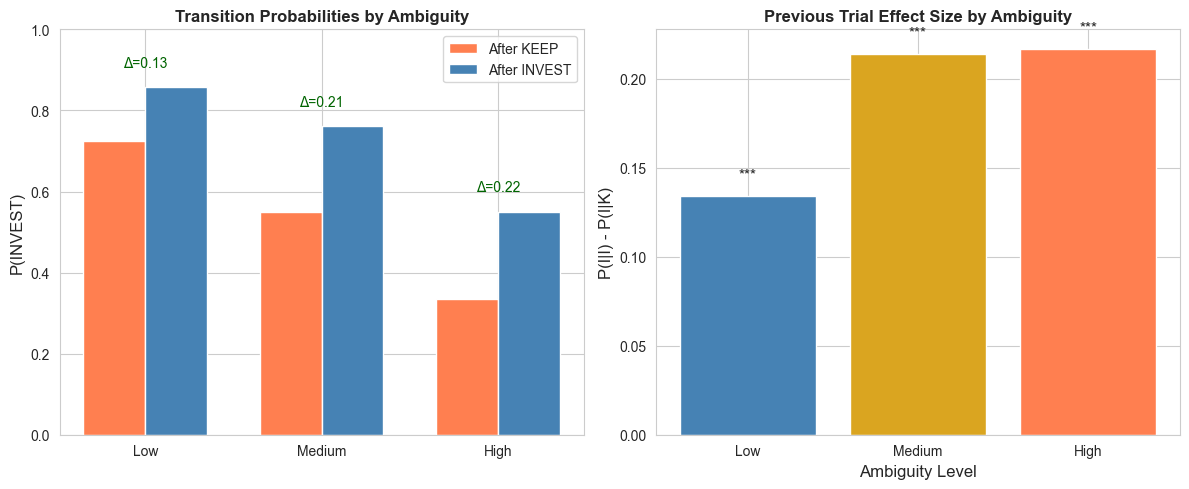

In [24]:
# Visualize transition probabilities by ambiguity
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. Transition probabilities comparison
ax1 = axes[0]
x = np.arange(len(transition_df))
width = 0.35

bars1 = ax1.bar(x - width/2, transition_df['P(I|K)'], width, label='After KEEP', color='coral')
bars2 = ax1.bar(x + width/2, transition_df['P(I|I)'], width, label='After INVEST', color='steelblue')

ax1.set_ylabel('P(INVEST)', fontsize=12)
ax1.set_title('Transition Probabilities by Ambiguity', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(transition_df['Ambiguity'])
ax1.legend()
ax1.set_ylim(0, 1)

# Add difference annotations
for i, (idx, row) in enumerate(transition_df.iterrows()):
    ax1.annotate(f"Δ={row['Difference']:.2f}", 
                 xy=(i, max(row['P(I|I)'], row['P(I|K)']) + 0.05),
                 ha='center', fontsize=10, color='darkgreen')

# 2. Effect size (difference) comparison
ax2 = axes[1]
colors = ['steelblue', 'goldenrod', 'coral']
bars = ax2.bar(transition_df['Ambiguity'], transition_df['Difference'], color=colors)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('P(I|I) - P(I|K)', fontsize=12)
ax2.set_xlabel('Ambiguity Level', fontsize=12)
ax2.set_title('Previous Trial Effect Size by Ambiguity', fontsize=12, fontweight='bold')

# Add significance stars
for i, (idx, row) in enumerate(transition_df.iterrows()):
    sig = '***' if row['p-value'] < 0.001 else '**' if row['p-value'] < 0.01 else '*' if row['p-value'] < 0.05 else 'ns'
    ax2.text(i, row['Difference'] + 0.01, sig, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

## 4. Model Comparison by Ambiguity

In [25]:
def evaluate_model(X, y, subjects, name, verbose=False):
    """Evaluate model using LOSO CV."""
    logo = LeaveOneGroupOut()
    accs = []
    
    unique_subjects = np.unique(subjects)
    if len(unique_subjects) < 3:
        from sklearn.model_selection import cross_val_score
        model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
        scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        return {'accuracy': np.mean(scores), 'accuracy_sem': stats.sem(scores)}
    
    for train_idx, test_idx in logo.split(X, y, subjects):
        model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        accs.append(accuracy_score(y[test_idx], y_pred))
    
    return {'accuracy': np.mean(accs), 'accuracy_sem': stats.sem(accs)}

def weighted_late_fusion(X_modalities, y, subjects):
    """Weighted late fusion."""
    logo = LeaveOneGroupOut()
    accs = []
    
    unique_subjects = np.unique(subjects)
    if len(unique_subjects) < 3:
        return {'accuracy': 0.5, 'accuracy_sem': 0.0}
    
    for train_idx, test_idx in logo.split(X_modalities[0], y, subjects):
        y_train, y_test = y[train_idx], y[test_idx]
        train_subjects = subjects[train_idx]
        
        n_inner = min(5, len(np.unique(train_subjects)) - 1)
        if n_inner < 2:
            n_inner = 2
        
        train_probs = np.zeros((len(train_idx), len(X_modalities)))
        gkf_inner = GroupKFold(n_splits=n_inner)
        
        for inner_train_idx, inner_val_idx in gkf_inner.split(
            X_modalities[0][train_idx], y_train, train_subjects
        ):
            abs_inner_train = train_idx[inner_train_idx]
            abs_inner_val = train_idx[inner_val_idx]
            
            for mod_i, X in enumerate(X_modalities):
                model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
                model.fit(X[abs_inner_train], y[abs_inner_train])
                train_probs[inner_val_idx, mod_i] = model.predict_proba(X[abs_inner_val])[:, 1]
        
        test_probs = []
        for X in X_modalities:
            model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
            model.fit(X[train_idx], y_train)
            test_probs.append(model.predict_proba(X[test_idx])[:, 1])
        test_probs = np.column_stack(test_probs)
        
        meta = LogisticRegression(random_state=42, max_iter=1000)
        meta.fit(train_probs, y_train)
        y_pred = meta.predict(test_probs)
        accs.append(accuracy_score(y_test, y_pred))
    
    return {'accuracy': np.mean(accs), 'accuracy_sem': stats.sem(accs)}

In [26]:
print("\n" + "="*70)
print("MODEL COMPARISON BY AMBIGUITY")
print("="*70)

model_results = []

for group in df_valid['ambiguity_group'].cat.categories:
    print(f"\n--- {group} Ambiguity ---")
    df_group = df_valid[df_valid['ambiguity_group'] == group].copy()
    df_group = df_group.reset_index(drop=True)
    
    # Prepare features
    X_physio = StandardScaler().fit_transform(
        SimpleImputer(strategy='mean').fit_transform(df_group[physio_cols]))
    X_behavior = StandardScaler().fit_transform(
        SimpleImputer(strategy='mean').fit_transform(df_group[behavior_cols]))
    X_gaze = StandardScaler().fit_transform(
        SimpleImputer(strategy='mean').fit_transform(df_group[gaze_cols])) if len(gaze_cols) > 0 else np.zeros((len(df_group), 1))
    X_sequential = StandardScaler().fit_transform(
        SimpleImputer(strategy='mean').fit_transform(df_group[sequential_cols]))
    
    y = df_group['outcome'].values
    subjects = df_group['subject_id'].values
    
    # Baseline: P+B+G
    results_baseline = weighted_late_fusion([X_physio, X_behavior, X_gaze], y, subjects)
    print(f"  Baseline (P+B+G): {results_baseline['accuracy']:.3f}")
    
    # With Sequential: P+B+G+S
    results_with_seq = weighted_late_fusion([X_physio, X_behavior, X_gaze, X_sequential], y, subjects)
    print(f"  With Sequential: {results_with_seq['accuracy']:.3f}")
    
    # Sequential only
    results_seq = evaluate_model(X_sequential, y, subjects, "Sequential")
    print(f"  Sequential Only: {results_seq['accuracy']:.3f}")
    
    improvement = results_with_seq['accuracy'] - results_baseline['accuracy']
    print(f"  Improvement: {improvement:+.3f}")
    
    model_results.append({
        'Ambiguity': group,
        'N': len(df_group),
        'Baseline': results_baseline['accuracy'],
        'With_Sequential': results_with_seq['accuracy'],
        'Sequential_Only': results_seq['accuracy'],
        'Improvement': improvement
    })

model_df = pd.DataFrame(model_results)
print("\n" + model_df.to_string(index=False))


MODEL COMPARISON BY AMBIGUITY

--- Low Ambiguity ---
  Baseline (P+B+G): 0.806
  With Sequential: 0.806
  Sequential Only: 0.585
  Improvement: +0.000

--- Medium Ambiguity ---
  Baseline (P+B+G): 0.684
  With Sequential: 0.718
  Sequential Only: 0.667
  Improvement: +0.034

--- High Ambiguity ---
  Baseline (P+B+G): 0.582
  With Sequential: 0.656
  Sequential Only: 0.648
  Improvement: +0.074

Ambiguity    N  Baseline  With_Sequential  Sequential_Only  Improvement
      Low 4143  0.806131         0.806151         0.584759     0.000020
   Medium 4129  0.683508         0.717700         0.667332     0.034192
     High 4142  0.582498         0.656268         0.647879     0.073770


In [27]:
print("\n" + "="*70)
print(f"SUMMARY: PREVIOUS TRIAL EFFECTS BY AMBIGUITY ({TIMEFRAME})")
print("="*70)

print("\n1. TRANSITION PROBABILITY DIFFERENCES (P(I|I) - P(I|K)):")
for _, row in transition_df.iterrows():
    print(f"   {row['Ambiguity']:6} Ambiguity: Δ = {row['Difference']:.3f} (p={row['p-value']:.2e})")

# Compare effect sizes across all 3 groups
low_effect = transition_df[transition_df['Ambiguity'] == 'Low']['Difference'].values[0]
med_effect = transition_df[transition_df['Ambiguity'] == 'Medium']['Difference'].values[0]
high_effect = transition_df[transition_df['Ambiguity'] == 'High']['Difference'].values[0]

print(f"\n   → Previous trial effect trend: Low={low_effect:.3f}, Med={med_effect:.3f}, High={high_effect:.3f}")
if high_effect > low_effect:
    print(f"   → Effect INCREASES with ambiguity (High - Low = {high_effect - low_effect:+.3f})")
else:
    print(f"   → Effect DECREASES with ambiguity (High - Low = {high_effect - low_effect:+.3f})")

print("\n2. MODEL IMPROVEMENT FROM SEQUENTIAL FEATURES:")
for _, row in model_df.iterrows():
    print(f"   {row['Ambiguity']:6} Ambiguity: {row['Improvement']:+.3f} ({row['Baseline']:.3f} → {row['With_Sequential']:.3f})")

print("\n3. INTERPRETATION:")
low_imp = model_df[model_df['Ambiguity'] == 'Low']['Improvement'].values[0]
med_imp = model_df[model_df['Ambiguity'] == 'Medium']['Improvement'].values[0]
high_imp = model_df[model_df['Ambiguity'] == 'High']['Improvement'].values[0]

if high_imp > low_imp + 0.01:
    print("   ✓ Sequential features help MORE in high ambiguity trials")
    print("   ✓ When probabilities are uncertain, participants rely more on past behavior")
elif low_imp > high_imp + 0.01:
    print("   ✓ Sequential features help MORE in low ambiguity trials")
    print("   ✓ Clear probability trials still show strong sequential effects")
else:
    print("   ~ Sequential features help SIMILARLY across ambiguity levels")
    print("   ~ Previous trial effects are consistent regardless of uncertainty")

print("\n" + "="*70)


SUMMARY: PREVIOUS TRIAL EFFECTS BY AMBIGUITY (PRE)

1. TRANSITION PROBABILITY DIFFERENCES (P(I|I) - P(I|K)):
   Low    Ambiguity: Δ = 0.134 (p=3.76e-25)
   Medium Ambiguity: Δ = 0.214 (p=4.52e-45)
   High   Ambiguity: Δ = 0.217 (p=2.36e-40)

   → Previous trial effect trend: Low=0.134, Med=0.214, High=0.217
   → Effect INCREASES with ambiguity (High - Low = +0.083)

2. MODEL IMPROVEMENT FROM SEQUENTIAL FEATURES:
   Low    Ambiguity: +0.000 (0.806 → 0.806)
   Medium Ambiguity: +0.034 (0.684 → 0.718)
   High   Ambiguity: +0.074 (0.582 → 0.656)

3. INTERPRETATION:
   ✓ Sequential features help MORE in high ambiguity trials
   ✓ When probabilities are uncertain, participants rely more on past behavior



## 5. Feature Importance by Ambiguity

In [28]:
print("\n" + "="*70)
print("FEATURE IMPORTANCE BY AMBIGUITY")
print("="*70)

# Compare feature importance across ambiguity groups
importance_by_group = {}

for group in df_valid['ambiguity_group'].cat.categories:
    df_group = df_valid[df_valid['ambiguity_group'] == group].copy()
    
    # Combine all features
    X_all = np.hstack([
        StandardScaler().fit_transform(SimpleImputer(strategy='mean').fit_transform(df_group[physio_cols])),
        StandardScaler().fit_transform(SimpleImputer(strategy='mean').fit_transform(df_group[behavior_cols])),
        StandardScaler().fit_transform(SimpleImputer(strategy='mean').fit_transform(df_group[gaze_cols])) if len(gaze_cols) > 0 else np.zeros((len(df_group), 1)),
        StandardScaler().fit_transform(SimpleImputer(strategy='mean').fit_transform(df_group[sequential_cols]))
    ])
    all_cols = physio_cols + behavior_cols + (gaze_cols if len(gaze_cols) > 0 else ['gaze_placeholder']) + sequential_cols
    y = df_group['outcome'].values
    
    model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    model.fit(X_all, y)
    
    importance_by_group[group] = dict(zip(all_cols, np.abs(model.coef_[0])))

# Compare sequential feature importance
print("\nSequential Feature Importance:")
seq_importance = pd.DataFrame({
    group: {col: importance_by_group[group].get(col, 0) for col in sequential_cols}
    for group in df_valid['ambiguity_group'].cat.categories
})
print(seq_importance.to_string())


FEATURE IMPORTANCE BY AMBIGUITY

Sequential Feature Importance:
                           Low    Medium      High
prev_outcome          0.050133  0.045433  0.113982
prev_outcome_2        0.060909  0.002401  0.000172
running_invest_rate   0.489282  0.846678  0.534051
recent_invest_rate_5  0.147099  0.127973  0.014298
trial_position        0.107835  0.121577  0.071932
consecutive_same      0.563950  0.789627  0.920627


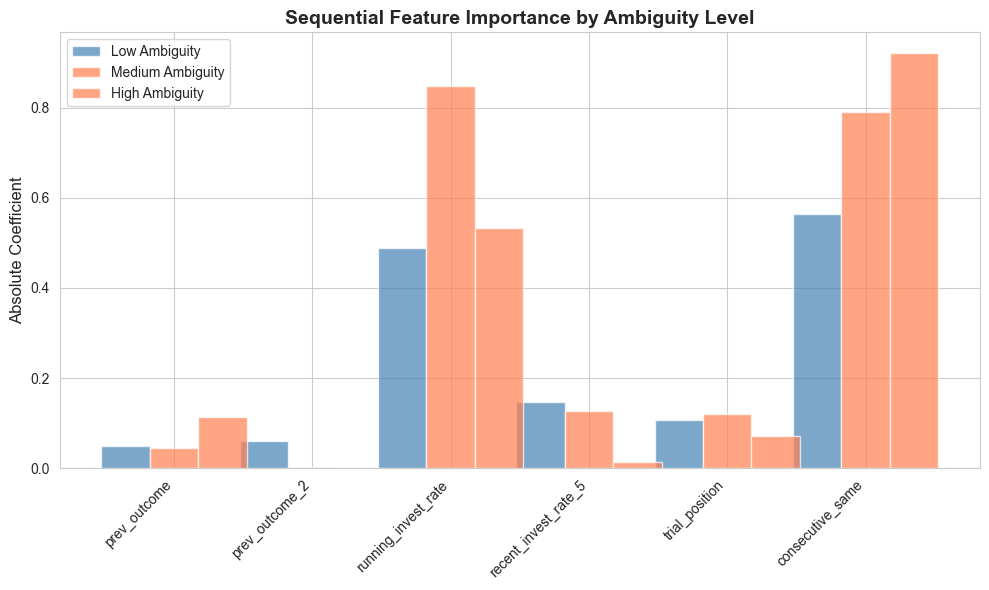

In [29]:
# Visualize sequential feature importance by ambiguity
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(sequential_cols))
width = 0.35
groups = list(df_valid['ambiguity_group'].cat.categories)

for i, group in enumerate(groups):
    offset = (i - len(groups)/2 + 0.5) * width
    values = [importance_by_group[group].get(col, 0) for col in sequential_cols]
    color = 'steelblue' if i == 0 else 'coral'
    ax.bar(x + offset, values, width, label=f'{group} Ambiguity', color=color, alpha=0.7)

ax.set_ylabel('Absolute Coefficient', fontsize=12)
ax.set_title('Sequential Feature Importance by Ambiguity Level', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(sequential_cols, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

## 6. Save Results

In [30]:
import os

output_dir = f'../../data/results/previous_trial_effects_{TIMEFRAME}'
os.makedirs(output_dir, exist_ok=True)

save_results(transition_df, f'{output_dir}/transitions_by_ambiguity_{TIMEFRAME}.csv')
save_results(model_df, f'{output_dir}/models_by_ambiguity_{TIMEFRAME}.csv')
save_results(seq_importance, f'{output_dir}/seq_importance_by_ambiguity_{TIMEFRAME}.csv')

print(f"\n✓ Results saved to: {output_dir}/")

✓ Saved results to: ../../data/results/previous_trial_effects_PRE/transitions_by_ambiguity_PRE.csv
✓ Saved results to: ../../data/results/previous_trial_effects_PRE/models_by_ambiguity_PRE.csv
✓ Saved results to: ../../data/results/previous_trial_effects_PRE/seq_importance_by_ambiguity_PRE.csv

✓ Results saved to: ../../data/results/previous_trial_effects_PRE/


## 7. Summary

In [31]:
print("\n" + "="*70)
print(f"SUMMARY: PREVIOUS TRIAL EFFECTS BY AMBIGUITY ({TIMEFRAME})")
print("="*70)

print("\n1. TRANSITION PROBABILITY DIFFERENCES:")
for _, row in transition_df.iterrows():
    print(f"   {row['Ambiguity']} Ambiguity: Δ = {row['Difference']:.3f} (p={row['p-value']:.2e})")

# Compare effect sizes
if len(transition_df) == 2:
    low_effect = transition_df[transition_df['Ambiguity'] == 'Low']['Difference'].values[0]
    high_effect = transition_df[transition_df['Ambiguity'] == 'High']['Difference'].values[0]
    print(f"\n   → Effect is {'STRONGER' if high_effect > low_effect else 'WEAKER'} in high ambiguity trials")
    print(f"   → Difference: {high_effect - low_effect:+.3f}")

print("\n2. MODEL IMPROVEMENT FROM SEQUENTIAL FEATURES:")
for _, row in model_df.iterrows():
    print(f"   {row['Ambiguity']} Ambiguity: {row['Improvement']:+.3f} ({row['Baseline']:.3f} → {row['With_Sequential']:.3f})")

print("\n3. INTERPRETATION:")
if len(model_df) == 2:
    low_imp = model_df[model_df['Ambiguity'] == 'Low']['Improvement'].values[0]
    high_imp = model_df[model_df['Ambiguity'] == 'High']['Improvement'].values[0]
    
    if high_imp > low_imp + 0.01:
        print("   ✓ Sequential features help MORE in high ambiguity trials")
        print("   ✓ When probabilities are uncertain, participants rely more on past behavior")
    elif low_imp > high_imp + 0.01:
        print("   ✓ Sequential features help MORE in low ambiguity trials")
        print("   ✓ Even with clear probabilities, past behavior influences decisions")
    else:
        print("   ~ Sequential features help SIMILARLY across ambiguity levels")
        print("   ~ Previous trial effects are consistent regardless of ambiguity")

print("\n" + "="*70)


SUMMARY: PREVIOUS TRIAL EFFECTS BY AMBIGUITY (PRE)

1. TRANSITION PROBABILITY DIFFERENCES:
   Low Ambiguity: Δ = 0.134 (p=3.76e-25)
   Medium Ambiguity: Δ = 0.214 (p=4.52e-45)
   High Ambiguity: Δ = 0.217 (p=2.36e-40)

2. MODEL IMPROVEMENT FROM SEQUENTIAL FEATURES:
   Low Ambiguity: +0.000 (0.806 → 0.806)
   Medium Ambiguity: +0.034 (0.684 → 0.718)
   High Ambiguity: +0.074 (0.582 → 0.656)

3. INTERPRETATION:

